# Renewables Case Study: Double Loop Optimization

In [1]:
import pyomo.environ as pyo
from pyomo.common.dependencies import check_min_version
import idaes

if not check_min_version(idaes, '2.0.0.a4'):
    raise EnvironmentError("This notebook requires the 2.0.0.a4 pre-release of idaes-pse, which can be found here: https://github.com/dguittet/idaes-pse/tree/2.0.0.a4")

from dispatches_sample_data import rts_gmlc
from dispatches.models.renewables_case.wind_battery_double_loop import MultiPeriodWindBattery
from dispatches.models.renewables_case.double_loop_utils import *

for solver in ('xpress_direct', 'gurobi', 'cbc'):
    if pyo.SolverFactory(solver).available(exception_flag=False):
        milp_solver = solver
        break

## Creating the Co-simulation of the Wind and Battery IES within the Production Cost Model with Bidder and Tracker Models

In the [Conceptual Design Optimization Example Notebook](./ConceptualDesignOptimization.ipynb), the design of a Wind + Battery + Hydrogen integrated energy system was optimized using the RTS-GMLC outputs with a "price taker" assumption. Here, we take one of the possible results, a Wind + Battery IES with no Hydrogen, and evaluate its performance in an electricity market by co-simulating its bidding and operation decisions within the production cost model, Prescient, in a "double-loop" optimization.

This double-loop is performed by embedding the multiperiod Wind + Battery flowsheet model as a `MultiPeriodWindBattery` within a `Bidder` and a `Tracker` model, whose functions are to optimize the Day-ahead or Real-time energy market bids, and to optimize the operation of the IES to follow the cleared market's dispatch, respectively. These functions are coordinated in order and with the correct data transfers with Prescient by a `DoubleLoopCoordinator` class. Prescient is then able to evaluate the economic performance of the designed IES within the grid with market interactions and forecast uncertainty. The steps are as shown in this diagram:

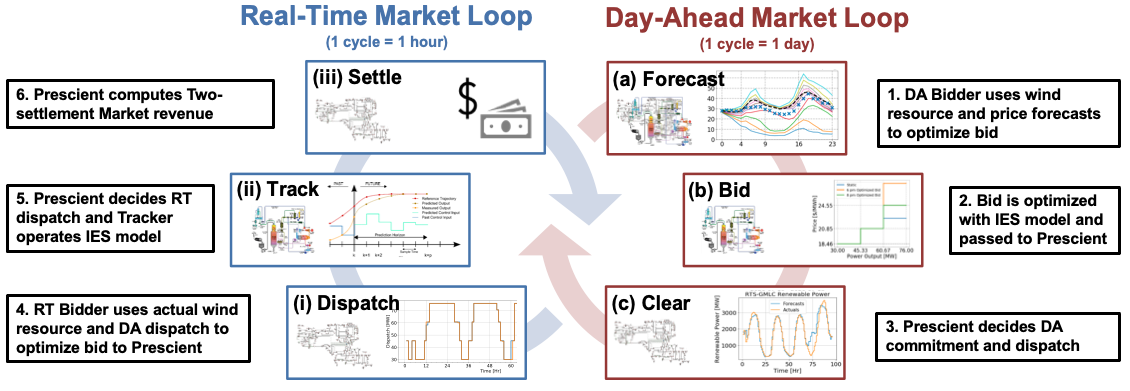

In the Day-ahead loop, the Unit Commitment Problem is solved by forecasting loads and obtaining generator bids, and produces hourly schedules and LMPs. The `Bidder` will use forecasts and plant information to optimize the DA bid to Prescient.

In the Real-time loop, the Economic Dispatch Problem is solved using real-time loads and resources to produce updated generator dispatch points and commitments. The `Bidder` will use forecasts, DA dispatch and prices, and plant information to optimize the updated RT bid. Once the Real-time market is cleared, the `Tracker` controls the IES to implement the dispatch at lowest cost. 

The market participants are paid on energy and/or reserve provided based on the two-settlement system:

$$R = Q_{DA} \times P_{DA} + (Q_{RT} - Q_{DA}) \times P_{RT}$$

where $R$ is revenue, $Q_{DA}$ is power sold to DA market at $P_{DA}$ price, and $Q_{RT}$ is power delivered to RT market at $P_{RT}$ price.

First, we define the electricity grid for the double-loop simulation via options to Prescient: the directory to the RTS-GMLC source data, the time horizons for the UC and ED problems, the start date and length of the simulation, how much reserves should be procured, etc. The full-year PCM simulation was completed prior and the outputs were collected into a `309_WIND_1-SimulationOutputs.csv` in order to provide "historical" LMPs and Wind resource capacity factors for the Conceptual Design Optimization.

In this example, we will repeat the Prescient simulation with no reserves for a single week, where the Wind + Battery IES will replace the `309_WIND_1` Wind plant at the "Carter" bus.

In [2]:
from prescient.simulator import Prescient
import os

start_date = "01-02-2020"
sim_days = 7
day_ahead_horizon = 48
real_time_horizon = 4
output_dir = Path(f"double_loop_results")

wind_bus = 309
wind_bus_name = "Carter"
wind_generator = f"{wind_bus}_WIND_1"

prescient_options = {
    "data_path": rts_gmlc.source_data_path,
    "input_format": "rts-gmlc",
    "simulate_out_of_sample": True,
    "run_sced_with_persistent_forecast_errors": True,
    "output_directory": output_dir,
    "start_date": start_date,
    "num_days": sim_days,
    "sced_horizon": real_time_horizon,
    "ruc_horizon": day_ahead_horizon,
    "compute_market_settlements": True,
    "day_ahead_pricing": "LMP",
    "ruc_mipgap": 0.05,
    "symbolic_solver_labels": True,
    "reserve_factor": 0,
    "deterministic_ruc_solver": milp_solver,
    "sced_solver": milp_solver,
    "plugin": {
        "doubleloop": {
            "module": None,                                          # to be added below
            "bidding_generator": wind_generator,
        }
    }
}

# collect "historical" full-year wind forecast and first-day LMPs
prescient_outputs_df = pd.read_csv(Path(os.path.realpath("__file__")).parent / "data" / "309_WIND_1-SimulationOutputs.csv")
prescient_outputs_df.index = pd.to_datetime(prescient_outputs_df['Unnamed: 0'])
prescient_outputs_df = prescient_outputs_df[prescient_outputs_df.index >= pd.Timestamp(f'{start_date} 00:00:00')]
gen_capacity_factor = prescient_outputs_df[f"{wind_generator}-RTCF"].values.tolist()
historical_da_prices = {
    wind_bus_name: prescient_outputs_df[f"LMP DA"].values[0:24].tolist()
}
historical_rt_prices = {
    wind_bus_name: prescient_outputs_df[f"LMP"].values[0:24].tolist()
}

Interactive Python mode detected; using default matplotlib backend for plotting.


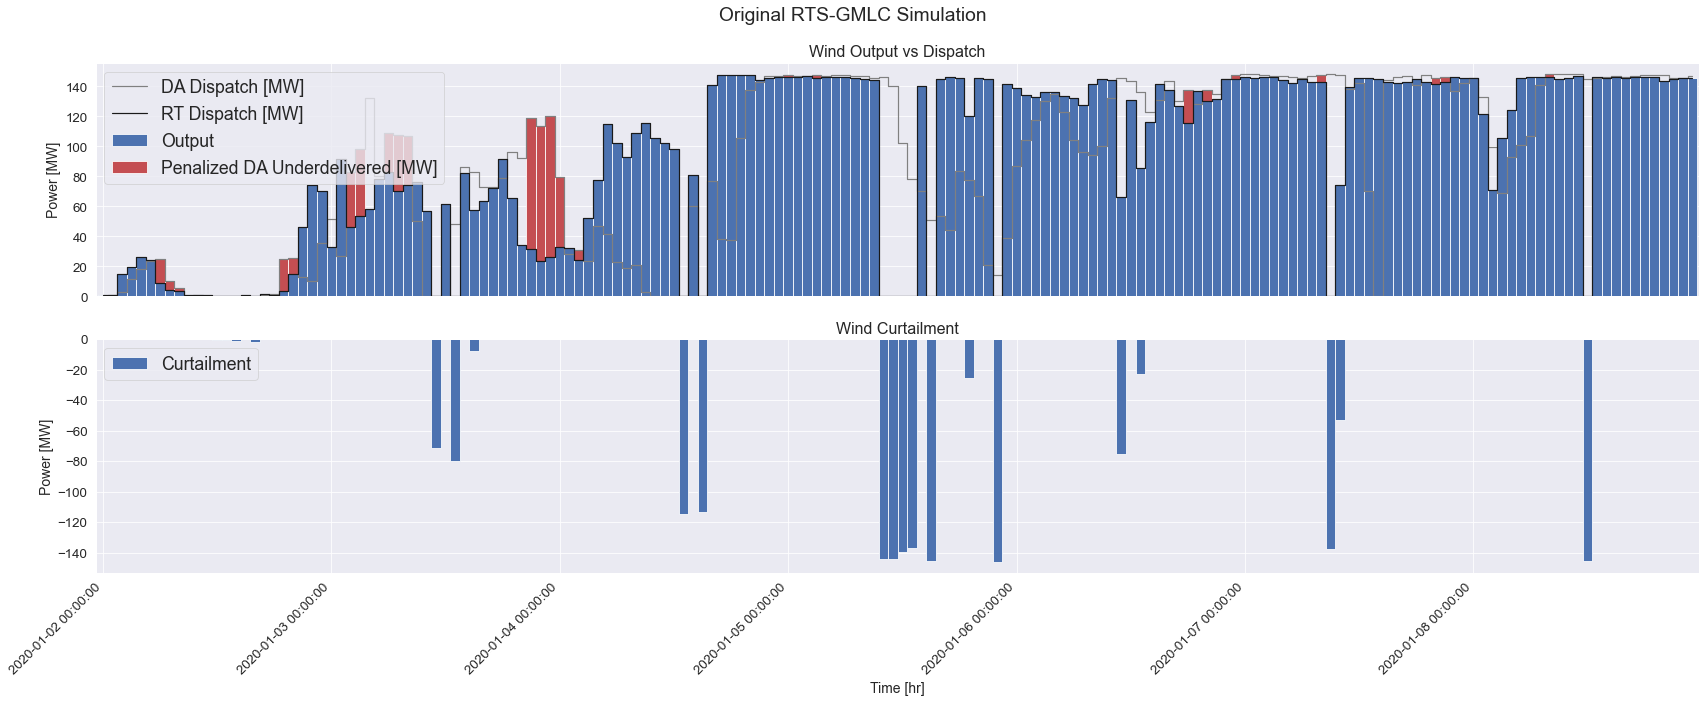

In [3]:
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16, 'axes.titlesize': 16, 'axes.labelsize': 14})

def format_plt(fig, ax, titles, suptitle=None, mod_ticks=True, y_labels=None):
    if not y_labels:
        y_labels = ["Power [MW]"] * len(ax)
    for i in range(len(ax)):
        if mod_ticks:
            ax[i].xaxis.set_minor_locator(MultipleLocator(4))
            ax[i].xaxis.set_major_locator(MultipleLocator(24))
            ax[i].tick_params(axis='both', which='major', labelsize="small")
            ax[i].tick_params(axis='both', which='minor', labelsize="small")
        ax[i].legend()
        ax[i].set_ylabel(y_labels[i])
        ax[i].set_xlabel("Time [hr]")
        ax[i].set_title(titles[i])
    fig.autofmt_xdate(rotation=45)
    if suptitle:
        fig.suptitle(suptitle)
    fig.tight_layout()

time_index = prescient_outputs_df[prescient_outputs_df.index <= '2020-01-08 23:00:00'].index
orig_outputs_df = prescient_outputs_df[prescient_outputs_df.index.isin(time_index)].copy()
orig_outputs_df['Penalized DA Underdelivered [MW]'] = (orig_outputs_df['Output DA'] - orig_outputs_df['Output']) * (orig_outputs_df['LMP'] > orig_outputs_df['LMP DA'])
orig_outputs_df.loc[:, 'Penalized DA Underdelivered [MW]'].clip(lower=0, inplace=True)
orig_outputs_df['Curtailment'] *= -1

fig, ax = plt.subplots(2, 1, figsize=(24, 10), sharex=True)
ax[0].plot(orig_outputs_df['Output DA'].values, drawstyle="steps-mid", label='DA Dispatch [MW]', color='grey')
ax[0].plot(orig_outputs_df['Output'].values, drawstyle="steps-mid", label='RT Dispatch [MW]', color='k')
cols = ['Output', 'Penalized DA Underdelivered [MW]']
orig_outputs_df[cols].plot(kind='bar', width=1, stacked=True, ax=ax[0], color=['b', 'r'])
orig_outputs_df['Curtailment'].plot(kind='bar', width=1, stacked=True, ax=ax[1])
format_plt(fig, ax, titles=["Wind Output vs Dispatch", "Wind Curtailment"], suptitle="Original RTS-GMLC Simulation")

The above plot shows the wind plant's `DA Dispatch`, `RT Dispatch`, `Wind Power Output`, `Penalized DA Underdelivered`, and `Wind Curtailment` in MW for the first week. The DA and RT Dispatch profiles are from the final solution of Prescient's staggered and forward-rolling UC and ED problems, and are based on the day-ahead and real-time wind forecast, respectively. 

The `Wind Power Output` is the real-time wind production of the wind plant, and matches the `RT Dispatch` exactly. However, since there was uncertainty of the RT wind resource during the DA bid, the `DA Dispatch` is different. According to the two-settlement system revenue equation above, the wind plant will be charged the RT LMP for the difference between the promised DA Dispatch and the delivered RT power. The `Penalized DA Underdelivered` profile show the power that was underdelivered when RT LMPs were higher than DA LMPs and resulted in some negative revenue for the plant.

The second plot below shows the Hourly and Cumulative revenue of the wind plant.

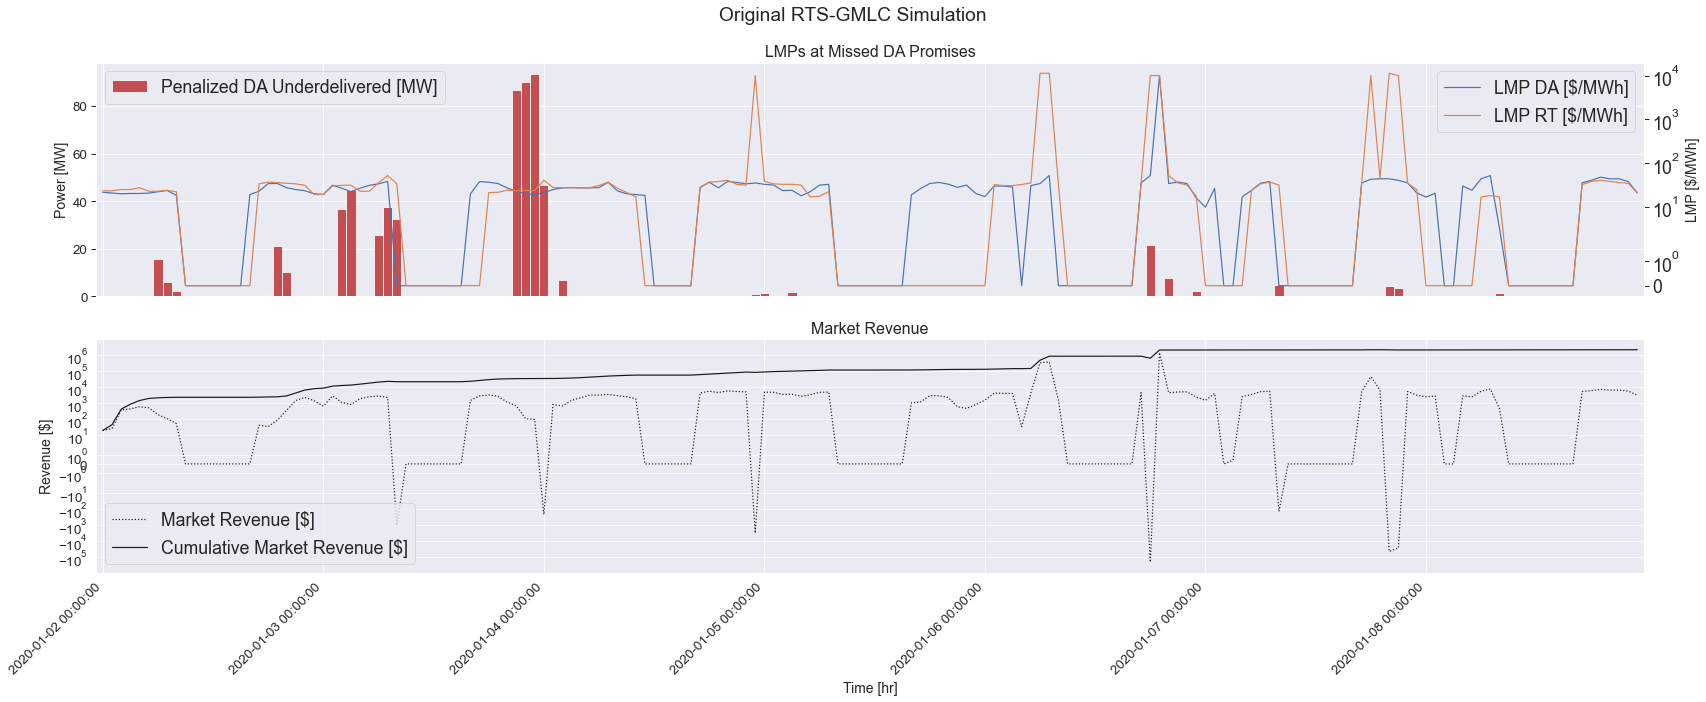

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(24, 10), sharex=True)

orig_outputs_df['Penalized DA Underdelivered [MW]'].plot(ax=ax[0], color='r', kind='bar', width=1)
ax0 = ax[0].twinx()
ax0.set_yscale('symlog')
ax0.plot(orig_outputs_df['LMP DA'].values, label="LMP DA [$/MWh]")
ax0.plot(orig_outputs_df['LMP'].values, label='LMP RT [$/MWh]')
ax0.legend(loc='upper right')
ax0.grid(None)
ax0.set_ylabel("LMP [$/MWh]")
ax[1].set_yscale('symlog')
ax[1].plot(orig_outputs_df['Unit Market Revenue'].values, color='k', linestyle=':', label="Market Revenue [$]")
ax[1].plot(orig_outputs_df['Unit Market Revenue'].cumsum().values, color='k', label="Cumulative Market Revenue [$]")

format_plt(fig, ax, y_labels=['Power [MW]', 'Revenue [$]'], titles=["LMPs at Missed DA Promises", "Market Revenue"], suptitle="Original RTS-GMLC Simulation")
ax[0].legend(loc='upper left')

## Creating the IES Generator within the RTS-GMLC

First, the location, type, capacity, and other parameters of the IES needs to be defined in order to situate the generator within the electricity market. In this example, the IES' bid will be represented as that of a thermal generator, with parameters such as min power, max power, ramping constraints, startup and shutdown capacity, even though the IES will not need them all. The wind resource at the chosen location, at the "Carter" bus, is read from the RTS-GMLC Source Data.

The information is passed to the `MultiPeriodWindBattery` class, which enables the `Bidder` and `Tracker` to construct a Wind + Battery multiperiod model within its bidding and tracking optimization problems via `populate_model`, and to update the state of the Wind + Battery IES as the double-loop steps forward in time via `update_model`.

In [5]:
from idaes.apps.grid_integration.model_data import ThermalGeneratorModelData

p_min = 0
wind_pmax = 147.6
battery_pmax = 25
battery_emax = battery_pmax * 4

# for descriptions on what each parameter means, see `help(ThermalGeneratorModelData)`
thermal_generator_params = {
    "gen_name": wind_generator,
    "bus": wind_bus_name,
    "p_min": p_min,
    "p_max": wind_pmax,
    "min_down_time": 0,
    "min_up_time": 0,
    "ramp_up_60min": wind_pmax + battery_pmax,
    "ramp_down_60min": wind_pmax + battery_pmax,
    "shutdown_capacity": wind_pmax + battery_pmax,
    "startup_capacity": 0,
    "initial_status": 1,
    "initial_p_output": 0,
    "production_cost_bid_pairs": [(p_min, 0), (wind_pmax, 0)],
    "startup_cost_pairs": [(0, 0)],
    "fixed_commitment": None,
}
model_data = ThermalGeneratorModelData(**thermal_generator_params)

mp_wind_battery_bid = MultiPeriodWindBattery(
    model_data=model_data,
    wind_capacity_factors=gen_capacity_factor,
    wind_pmax_mw=wind_pmax,
    battery_pmax_mw=battery_pmax,
    battery_energy_capacity_mwh=battery_emax,
)

## Creating the Forecaster, Tracker, and Bidder for the DoupleLoopCoordinator

The `Bidder` requires a forecast of the DA and RT prices in order to plan out its energy bid: at what time to sell how much energy and at what price, given the anticipated wind resource and the evolution of the battery state-of-charge. In contrast to the price-taker assumption in the Conceptual Design phase where the Wind + Battery IES took the historical LMPs for however much energy it sold, here, the `Bidder` does not know what the final LMP will be, nor that its bid for energy at a certain marginal cost will be accepted by the market. 

The `Backcaster` class stores historical DA and RT LMPs in order to generate forecast scenarios. The first day of simulated DA and RT LMPs initializes the `Backcaster`, which continues to collect resolved LMPs as the simulation steps forward in time. 

Within the `DoubleLoopCoordinator`, there are two `Tracker` objects, the first `tracker` follows the real-time market signals whereas the second `projection_tracker` projects the latest real-time dispatch onto the next day-ahead bidding problem. 

In [6]:
from idaes.apps.grid_integration.forecaster import Backcaster
from idaes.apps.grid_integration import Tracker, DoubleLoopCoordinator, Bidder

# Backcaster
help(Backcaster)
backcaster = Backcaster(historical_da_prices, historical_rt_prices)

Help on class Backcaster in module idaes.apps.grid_integration.forecaster:

class Backcaster(AbstractPrescientPriceForecaster)
 |  Backcaster(historical_da_prices, historical_rt_prices, max_historical_days=10)
 |  
 |  Generate price forecasts by directly using historical prices.
 |  
 |  Method resolution order:
 |      Backcaster
 |      AbstractPrescientPriceForecaster
 |      AbstractPriceForecaster
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, historical_da_prices, historical_rt_prices, max_historical_days=10)
 |      Initialize the Backcaster.
 |      
 |      Arguments:
 |          historical_da_prices: dictionary of list for historical hourly day-ahead prices
 |      
 |          historical_rt_prices: dictionary of list for historical hourly real-time prices
 |      
 |          max_historical_days: maximum number of days of price data to store on the instance
 |      
 |      Returns:
 |          None
 |  
 |  fetch_day_ahead_st

In [7]:
n_price_scenario = 3
solver = pyo.SolverFactory(milp_solver)

# Bidder
help(Bidder)
bidder_mp_wind_battery = MultiPeriodWindBattery(
    model_data=model_data,
    wind_capacity_factors=gen_capacity_factor,
    wind_pmax_mw=wind_pmax,
    battery_pmax_mw=battery_pmax,
    battery_energy_capacity_mwh=battery_emax,
)

bidder_object = Bidder(
    bidding_model_object=bidder_mp_wind_battery,
    day_ahead_horizon=day_ahead_horizon,
    real_time_horizon=real_time_horizon,
    n_scenario=n_price_scenario,
    solver=solver,
    forecaster=backcaster,
)

Help on class Bidder in module idaes.apps.grid_integration.bidder:

class Bidder(StochasticProgramBidder)
 |  Bidder(bidding_model_object, day_ahead_horizon, real_time_horizon, n_scenario, solver, forecaster)
 |  
 |  Wrap a model object to bid into the market using stochastic programming.
 |  
 |  Method resolution order:
 |      Bidder
 |      StochasticProgramBidder
 |      AbstractBidder
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, bidding_model_object, day_ahead_horizon, real_time_horizon, n_scenario, solver, forecaster)
 |      Initializes the bidder object.
 |      
 |      Arguments:
 |          bidding_model_object: the model object for bidding
 |      
 |          day_ahead_horizon: number of time periods in the day-ahead bidding problem
 |      
 |          real_time_horizon: number of time periods in the real-time bidding problem
 |      
 |          n_scenario: number of uncertain LMP scenarios
 |      
 |          solver: 

In [8]:
tracking_horizon = 4
n_tracking_hour = 1

# Tracker
help(Tracker)
tracker_mp_wind_battery = MultiPeriodWindBattery(
    model_data=model_data,
    wind_capacity_factors=gen_capacity_factor,
    wind_pmax_mw=wind_pmax,
    battery_pmax_mw=battery_pmax,
    battery_energy_capacity_mwh=battery_emax,
)

tracker_object = Tracker(
    tracking_model_object=tracker_mp_wind_battery,
    tracking_horizon=tracking_horizon,
    n_tracking_hour=n_tracking_hour,
    solver=solver,
)

# Projection Tracker
projection_mp_wind_battery = MultiPeriodWindBattery(
    model_data=model_data,
    wind_capacity_factors=gen_capacity_factor,
    wind_pmax_mw=wind_pmax,
    battery_pmax_mw=battery_pmax,
    battery_energy_capacity_mwh=battery_emax,
)

projection_tracker_object = Tracker(
    tracking_model_object=projection_mp_wind_battery,
    tracking_horizon=tracking_horizon,
    n_tracking_hour=n_tracking_hour,
    solver=solver,
)

Help on class Tracker in module idaes.apps.grid_integration.tracker:

class Tracker(builtins.object)
 |  Tracker(tracking_model_object, tracking_horizon, n_tracking_hour, solver)
 |  
 |  Wrap a model object to track the market dispatch signals. This class interfaces
 |  with the DoubleLoopCoordinator.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, tracking_model_object, tracking_horizon, n_tracking_hour, solver)
 |      Initializes the tracker object.
 |      
 |      Arguments:
 |          tracking_model_object: the model object for tracking
 |      
 |          tracking_horizon: number of time periods in the tracking problem
 |      
 |          n_tracking_hour: number of implemented hours after each solve
 |      
 |          solver: a Pyomo mathematical programming solver object
 |      
 |      Returns:
 |          None
 |  
 |  formulate_tracking_problem(self)
 |      Formulate the tracking optimization problem by adding necessary
 |      parameters, constraints, and obj

In [9]:
# Compose into Coordinator
help(DoubleLoopCoordinator)
coordinator = DoubleLoopCoordinator(
    bidder=bidder_object,
    tracker=tracker_object,
    projection_tracker=projection_tracker_object,
)

Help on class DoubleLoopCoordinator in module idaes.apps.grid_integration.coordinator:

class DoubleLoopCoordinator(builtins.object)
 |  DoubleLoopCoordinator(bidder, tracker, projection_tracker)
 |  
 |  Coordinate Prescient, tracker and bidder.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, bidder, tracker, projection_tracker)
 |      Initializes the DoubleLoopCoordinator object and registers functionalities
 |      in Prescient's plugin system.
 |      
 |      Arguments:
 |          bidder: an initialized bidder object
 |      
 |          tracker: an initialized tracker object
 |      
 |          projection_tracker: an initialized tracker object, this object is
 |                              mimicking the behaviror of the projection SCED in
 |                              Prescient and to projecting the system states
 |                              and updating bidder model.
 |      
 |      Returns:
 |          None
 |  
 |  activate_pending_DA_data(self, options, simul

## Running the Double-Loop Plugin

The prescient_options are updated with the DoubleLoopCoordinator. The simulation results will be written to the `output_dir` folder.

In [10]:
from types import ModuleType
import shutil

class PrescientPluginModule(ModuleType):
    def __init__(self, get_configuration, register_plugins):
        self.get_configuration = get_configuration
        self.register_plugins = register_plugins


plugin_module = PrescientPluginModule(
    get_configuration=coordinator.get_configuration,
    register_plugins=coordinator.register_plugins,
)

prescient_options['plugin']['doubleloop']['module'] = plugin_module

if output_dir.exists():
    shutil.rmtree(output_dir)
    
Prescient().simulate(**prescient_options)

In [11]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('seaborn')

df = double_loop_outputs_for_gen(output_dir, rts_gmlc.source_data_path)
prescient_df = df[df['Model'] == "Prescient"].copy()
da_bidder_df = df[df['Model'] == "DA Bidder"].copy()
rt_bidder_df = df[df['Model'] == "RT Bidder"].copy()
tracker_df = df[df['Model'] == "Tracker"].copy()
tracker_df.loc[:, 'Wind Curtailment [MW]'] = tracker_df['Wind Curtailment [MW]'] * -1
time_index = prescient_df.index
time_slice = slice(0, len(time_index))

da_bid_powers = [i for i in da_bidder_df.columns if 'DA Power' in i]
rt_bid_powers = [i for i in da_bidder_df.columns if 'RT Power' in i]

## Analyzing the Wind + Battery IES Performance: Bidder

In contrast to the wind plant above which bids its DA resource forecast and its RT resource forecast at $0/MWh marginal cost, the Wind + Battery IES is shifting the times and prices to sell energy. The bidding process for both the DA and RT market take place across multiple horizons within the staggered, forward-rolling UC and ED problems. As the Bidder receives more information about its state within each time horizon, it updates its bids. This is shown in the first plot in the top row, where the final DA and RT Bid are `24-Hr Ahead DA Bid` and `0-Hr Ahead RT Bid`. The second row shows the `DA Dispatch` and `RT Dispatch` from Prescient, and the delivered `RT Output`.

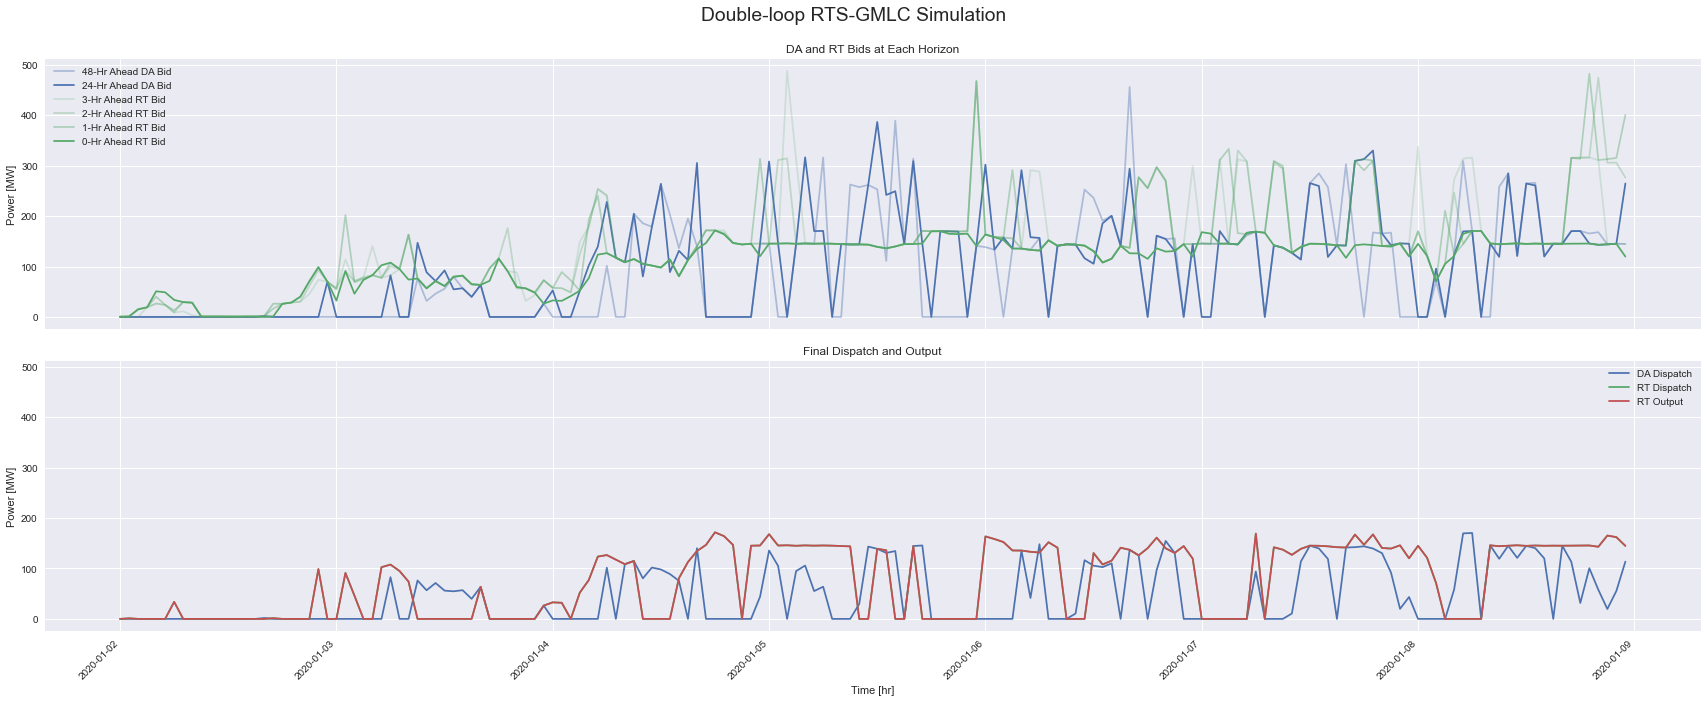

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(24, 10), sharex=True)
ax[0].plot(time_index, np.append([0] * 24, da_bidder_df[da_bidder_df['Horizon [hr]'] >= 24][da_bid_powers].sum(axis=1))[time_slice], color='b', alpha=0.4, label="48-Hr Ahead DA Bid")
ax[0].plot(time_index, da_bidder_df[da_bidder_df['Horizon [hr]'] < 24][da_bid_powers].sum(axis=1)[time_slice], color='b', alpha=1, label="24-Hr Ahead DA Bid")
ax[0].plot(time_index, np.append([0] * 3, rt_bidder_df[rt_bidder_df['Horizon [hr]'] == 3][rt_bid_powers].sum(axis=1))[time_slice], color='g', alpha=0.2, label="3-Hr Ahead RT Bid")
ax[0].plot(time_index, np.append([0] * 2, rt_bidder_df[rt_bidder_df['Horizon [hr]'] == 2][rt_bid_powers].sum(axis=1))[time_slice], color='g', alpha=0.3, label="2-Hr Ahead RT Bid")
ax[0].plot(time_index, np.append([0] * 1, rt_bidder_df[rt_bidder_df['Horizon [hr]'] == 1][rt_bid_powers].sum(axis=1))[time_slice], color='g', alpha=0.4, label="1-Hr Ahead RT Bid")
ax[0].plot(time_index, rt_bidder_df[rt_bidder_df['Horizon [hr]'] == 0]['RT Power 0 [MW]'].values[time_slice], color='g', alpha=1, label="0-Hr Ahead RT Bid")

ax[1].plot(time_index, prescient_df['Dispatch DA'].values[time_slice], color='b', label='DA Dispatch')
ax[1].plot(time_index, prescient_df['Dispatch'].values[time_slice], color='g', label='RT Dispatch')
ax[1].plot(time_index, tracker_df[tracker_df['Horizon [hr]'] == 0][['Power Output [MW]']], color='r', label='RT Output')
ax[1].set_ylim(ax[0].get_ylim())
format_plt(fig, ax, mod_ticks=False, titles=["DA and RT Bids at Each Horizon", "Final Dispatch and Output"], suptitle="Double-loop RTS-GMLC Simulation")

## Analyzing the Wind + Battery IES Performance: Tracker and Settlement

The first plot shows the double-loop simulation results. Max power has increased due to battery capacity. In comparison to the original result plotted above, there's different DA Dispatch due to using RT forecast instead of DA forecast. Also, where there were a few times where the wind plant had negative revenue due to `Penalized DA Underdelivered` when the RT price was higher than the DA price, here, there is only one instance of being penalized for missing a DA promise. However, there appears to be more curtailed energy, and the battery is full at least once a day, often more.

The second plot shows the impact on the Generator's `Unit Market Revenue`.

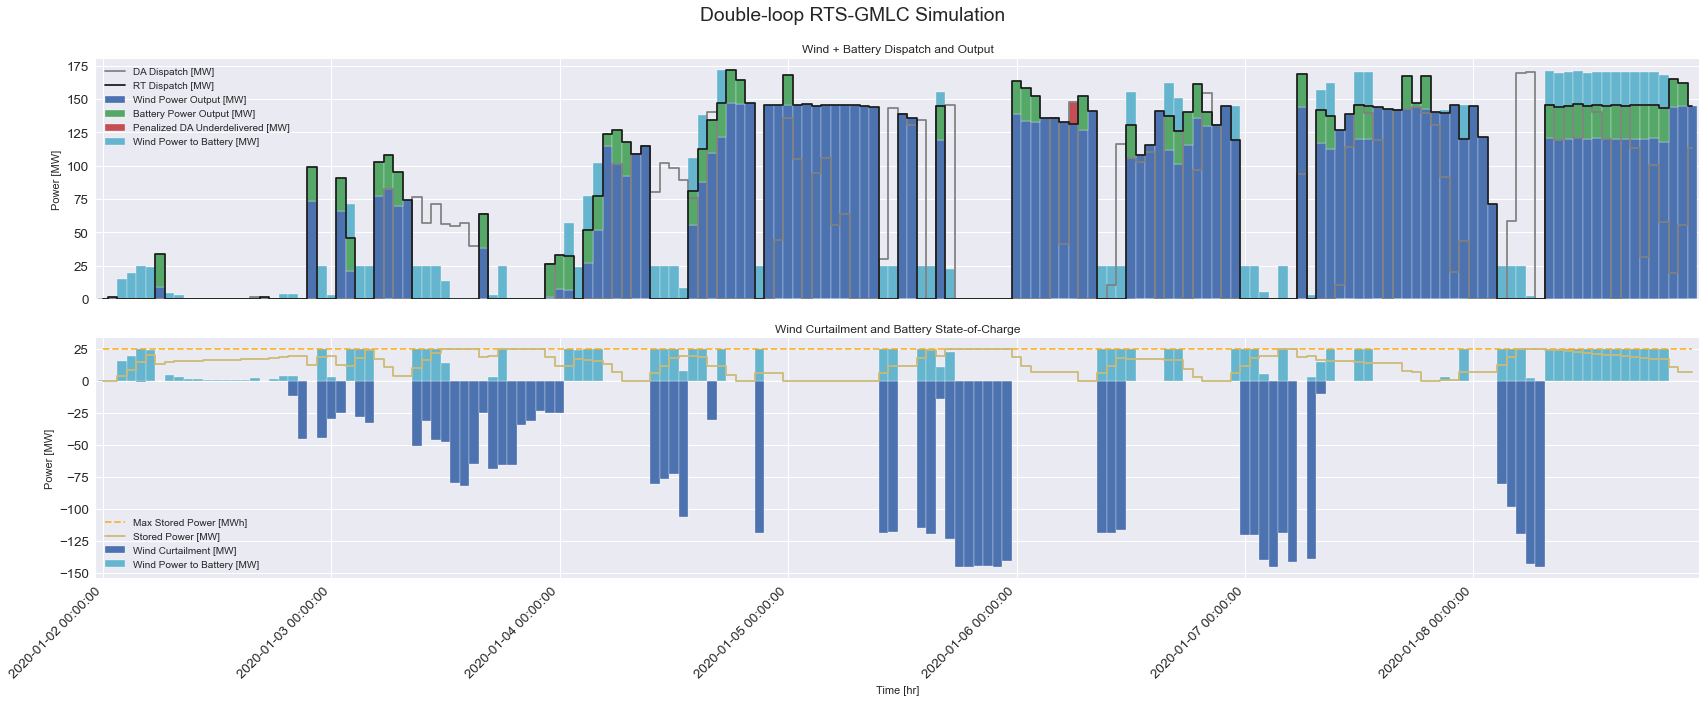

In [13]:
tracker_df.loc[:, 'Penalized DA Underdelivered'] = 0
prescient_df["Penalized DA Underdelivered"] = ((prescient_df['Dispatch DA'] - prescient_df['Dispatch']) * (prescient_df['LMP'] > prescient_df['LMP DA'])).clip(lower=0).values
tracker_df.loc[tracker_df['Horizon [hr]'] == 0, 'Penalized DA Underdelivered [MW]'] = prescient_df["Penalized DA Underdelivered"].values

fig, ax = plt.subplots(2, 1, figsize=(24, 10), sharex=True)
cols = ["Wind Power Output [MW]", "Battery Power Output [MW]", 'Penalized DA Underdelivered [MW]', "Wind Power to Battery [MW]"]
ax[0].plot(prescient_df['Dispatch DA'].values, drawstyle="steps-mid", label='DA Dispatch [MW]', color='grey')
ax[0].plot(tracker_df.loc[tracker_df['Horizon [hr]'] == 0]['Total Power Output [MW]'].values, drawstyle="steps-mid", label='RT Dispatch [MW]', color='k')
tracker_df.loc[tracker_df['Horizon [hr]'] == 0][cols].plot(kind='bar', width=1, stacked=True, ax=ax[0], color=['b', 'g', 'r', 'c'])

tracker_df.loc[tracker_df['Horizon [hr]'] == 0]['Wind Curtailment [MW]'].plot(kind='bar', width=1, stacked=True, ax=ax[1])
tracker_df.loc[tracker_df['Horizon [hr]'] == 0]["Wind Power to Battery [MW]"].plot(kind='bar', width=1, stacked=True, ax=ax[1], color='c')
ax[1].plot([battery_pmax] * len(time_index), linestyle="dashed", label='Max Stored Power [MWh]', alpha=0.8, color='orange')
ax[1].plot(tracker_df.loc[tracker_df['Horizon [hr]'] == 0]['State of Charge [MWh]'].values / 4, drawstyle="steps-mid", label='Stored Power [MW]', color='y')
format_plt(fig, ax, titles=["Wind + Battery Dispatch and Output", "Wind Curtailment and Battery State-of-Charge"], suptitle="Double-loop RTS-GMLC Simulation")

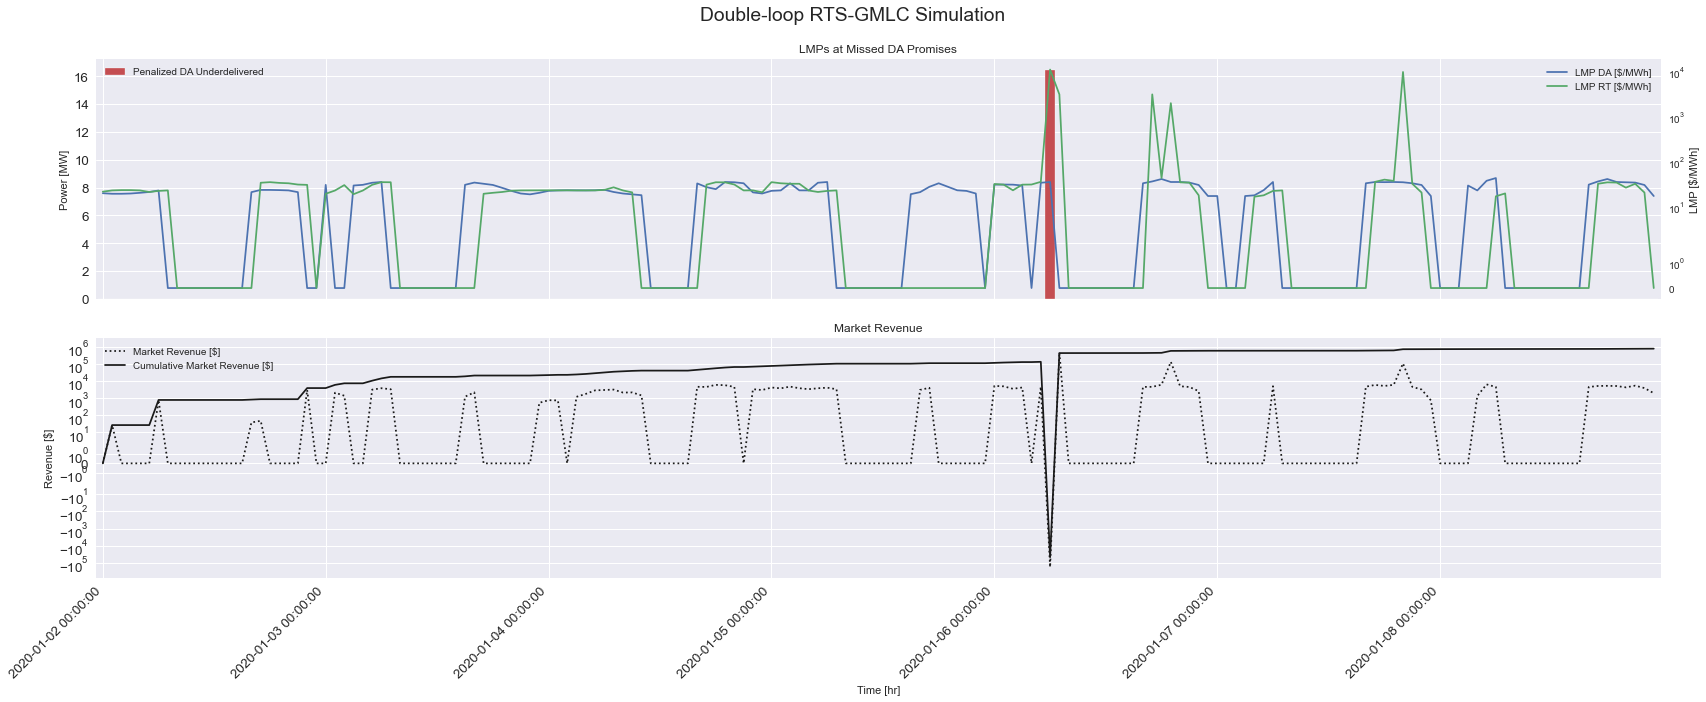

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(24, 10), sharex=True)
prescient_df["Penalized DA Underdelivered"].plot(ax=ax[0], color='r', kind='bar', width=1)
ax0 = ax[0].twinx()
ax0.set_yscale('symlog')
ax0.plot(prescient_df['LMP DA'].values, label="LMP DA [$/MWh]")
ax0.plot(prescient_df['LMP'].values, label='LMP RT [$/MWh]')
ax0.legend(loc='upper right')
ax0.set_ylabel("LMP [$/MWh]")
ax0.grid(None)
ax[1].set_yscale('symlog')
ax[1].plot(prescient_df['Unit Market Revenue'].values, color='k', linestyle=':', label="Market Revenue [$]")
ax[1].plot(prescient_df['Unit Market Revenue'].cumsum().values, color='k', label="Cumulative Market Revenue [$]")
format_plt(fig, ax, y_labels=['Power [MW]', 'Revenue [$]'], titles=["LMPs at Missed DA Promises", "Market Revenue"], suptitle="Double-loop RTS-GMLC Simulation")
ax[0].legend(loc='upper left')

## Analyzing the Wind + Battery IES Performance: Comparison to Original RTS-GMLC Simulation

The plots below show the changes in the electricity market which impact the plant's economic performance and the grid's production and reliability.

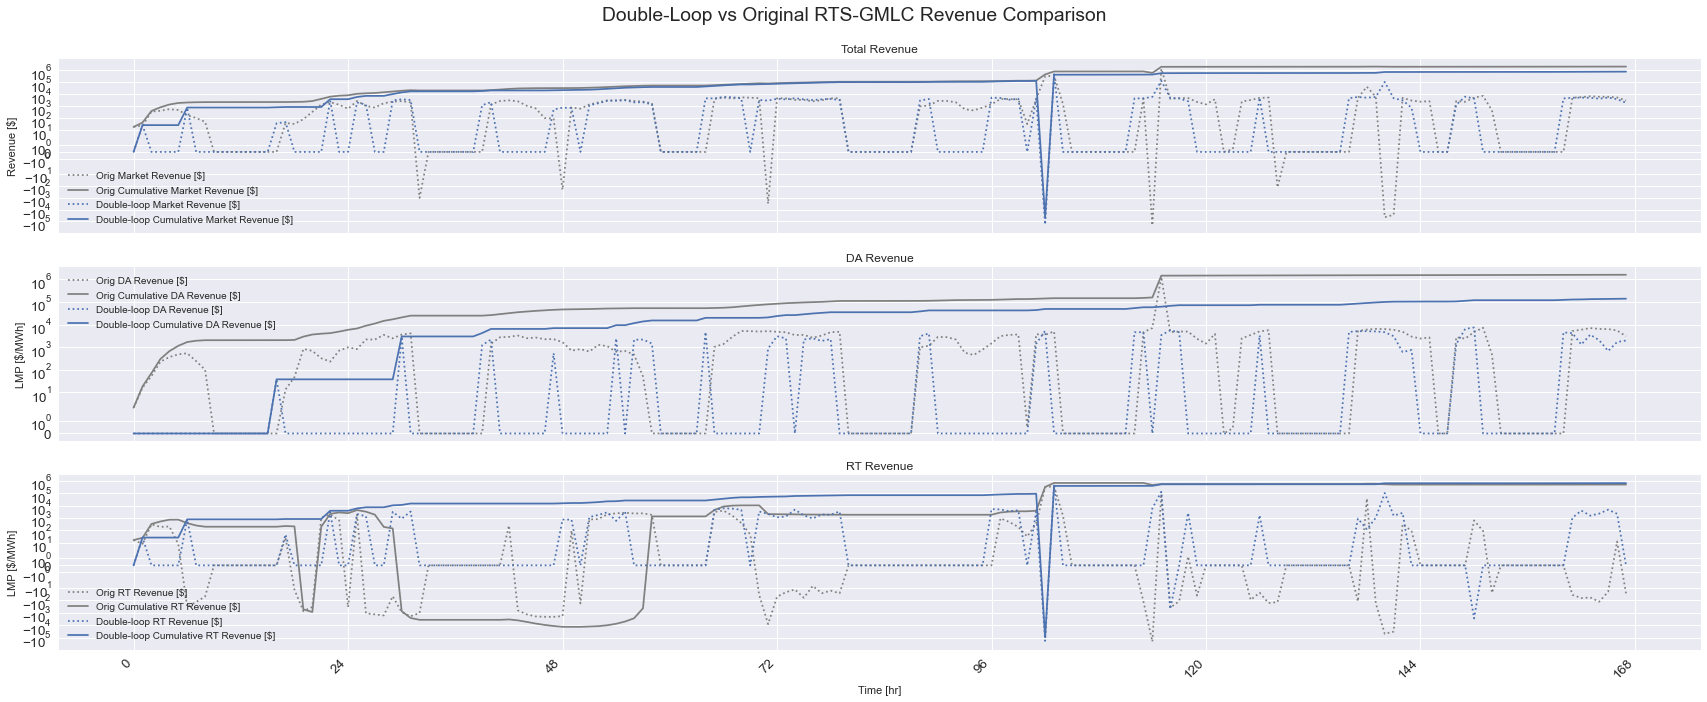

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(24, 10), sharex=True)
ax[0].set_yscale('symlog')
ax[0].plot(orig_outputs_df['Unit Market Revenue'].values, color='grey', linestyle=':', label="Orig Market Revenue [$]")
ax[0].plot(orig_outputs_df['Unit Market Revenue'].cumsum().values, color='grey', label="Orig Cumulative Market Revenue [$]")
ax[0].plot(prescient_df['Unit Market Revenue'].values, color='b', linestyle=':', label="Double-loop Market Revenue [$]")
ax[0].plot(prescient_df['Unit Market Revenue'].cumsum().values, color='b', label="Double-loop Cumulative Market Revenue [$]")

ax[1].set_yscale('symlog')
da_rev = orig_outputs_df['Output DA'] * orig_outputs_df['LMP DA']
ax[1].plot(da_rev.values, color='grey', linestyle=':', label="Orig DA Revenue [$]")
ax[1].plot(da_rev.cumsum().values, color='grey', label="Orig Cumulative DA Revenue [$]")
da_rev = prescient_df['Dispatch DA'] * prescient_df['LMP DA']
ax[1].plot(da_rev.values, color='b', linestyle=':', label="Double-loop DA Revenue [$]")
ax[1].plot(da_rev.cumsum().values, color='b', label="Double-loop Cumulative DA Revenue [$]")

ax[2].set_yscale('symlog')
rt_rev = (orig_outputs_df['Output'] - orig_outputs_df['Output DA']) * orig_outputs_df['LMP']
ax[2].plot(rt_rev.values, color='grey', linestyle=':', label="Orig RT Revenue [$]")
ax[2].plot(rt_rev.cumsum().values, color='grey', label="Orig Cumulative RT Revenue [$]")
rt_rev = (tracker_df[tracker_df['Horizon [hr]'] == 0]['Power Output [MW]'] - prescient_df['Dispatch DA']) * prescient_df['LMP']
ax[2].plot(rt_rev.values, color='b', linestyle=':', label="Double-loop RT Revenue [$]")
ax[2].plot(rt_rev.cumsum().values, color='b', label="Double-loop Cumulative RT Revenue [$]")

format_plt(fig, ax, y_labels=['Revenue [$]', "LMP [$/MWh]", "LMP [$/MWh]"], titles=["Total Revenue", 'DA Revenue', 'RT Revenue'], suptitle="Double-Loop vs Original RTS-GMLC Revenue Comparison")


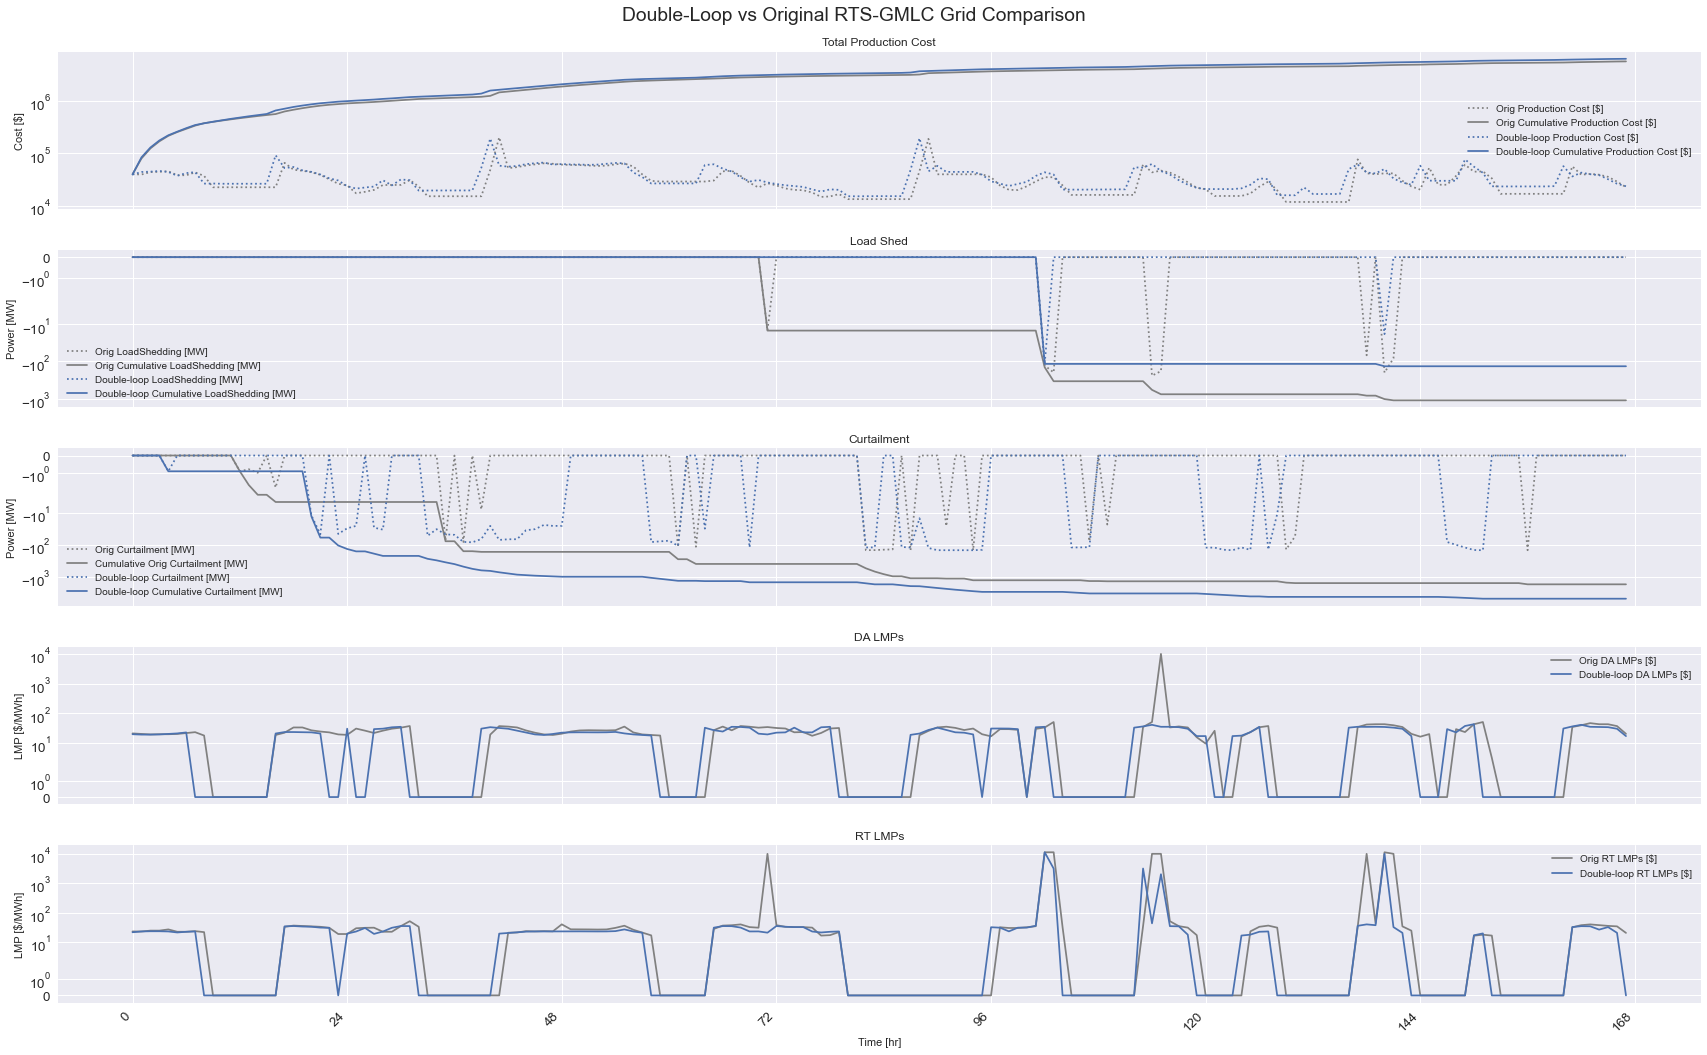

In [16]:
fig, ax = plt.subplots(5, 1, figsize=(24, 15), sharex=True)
ax[0].set_yscale('symlog')
ax[0].plot(orig_outputs_df['TotalCosts'].values, color='grey', linestyle=':', label="Orig Production Cost [$]")
ax[0].plot(orig_outputs_df['TotalCosts'].cumsum().values, color='grey', label="Orig Cumulative Production Cost [$]")
ax[0].plot(prescient_df['TotalCosts'].values, color='b', linestyle=':', label="Double-loop Production Cost [$]")
ax[0].plot(prescient_df['TotalCosts'].cumsum().values, color='b', label="Double-loop Cumulative Production Cost [$]")

ax[1].set_yscale('symlog')
ax[1].plot(orig_outputs_df['LoadShedding'].values * -1, color='grey', linestyle=':', label="Orig LoadShedding [MW]")
ax[1].plot(orig_outputs_df['LoadShedding'].cumsum().values * -1, color='grey', label="Orig Cumulative LoadShedding [MW]")
ax[1].plot(prescient_df['LoadShedding'].values * -1, color='b', linestyle=':', label="Double-loop LoadShedding [MW]")
ax[1].plot(prescient_df['LoadShedding'].cumsum().values * -1, color='b', label="Double-loop Cumulative LoadShedding [MW]")

ax[2].set_yscale('symlog')
ax[2].plot(orig_outputs_df['Curtailment'].values, color='grey', linestyle=':', label="Orig Curtailment [MW]")
ax[2].plot(orig_outputs_df['Curtailment'].cumsum().values, color='grey', label="Cumulative Orig Curtailment [MW]")
ax[2].plot(tracker_df[tracker_df['Horizon [hr]'] == 0]['Wind Curtailment [MW]'].values, color='b', linestyle=':', label="Double-loop Curtailment [MW]")
ax[2].plot(tracker_df[tracker_df['Horizon [hr]'] == 0]['Wind Curtailment [MW]'].cumsum().values, color='b', label="Double-loop Cumulative Curtailment [MW]")

ax[3].set_yscale('symlog')
ax[3].plot(orig_outputs_df['LMP DA'].values, color='grey', label="Orig DA LMPs [$]")
ax[3].plot(prescient_df['LMP DA'].values, color='b', label="Double-loop DA LMPs [$]")

ax[4].set_yscale('symlog')
ax[4].plot(orig_outputs_df['LMP'].values, color='grey', label="Orig RT LMPs [$]")
ax[4].plot(prescient_df['LMP'].values, color='b', label="Double-loop RT LMPs [$]")

format_plt(fig, ax, y_labels=['Cost [$]', "Power [MW]", "Power [MW]", "LMP [$/MWh]", "LMP [$/MWh]"], titles=["Total Production Cost", 'Load Shed', 'Curtailment', 'DA LMPs', 'RT LMPs'], suptitle="Double-Loop vs Original RTS-GMLC Grid Comparison")
